In [1]:
import json

from huggingface_hub import login
api_key_path = "/home/paperspace/api_keys.json"
with open(api_key_path, 'r') as j:
    key = json.loads(j.read())['hf-llama']
login(token=key)
    
import os
import pickle

import numpy as np
import matplotlib.pyplot as plt
from graspologic.embed import ClassicalMDS

from sentence_transformers import SentenceTransformer
from datasets import load_dataset, concatenate_datasets

from tqdm import tqdm
from taxi import utils, taxi

EMBEDDING_MODEL = SentenceTransformer("nomic-ai/nomic-embed-text-v1.5", trust_remote_code=True, device='cuda:0')

%load_ext autoreload
%autoreload 2

!!!!!!!!!!!!megablocks not available, using torch.matmul instead
<All keys matched successfully>


In [2]:
import gc
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling
)
from peft import (
    prepare_model_for_kbit_training,
    LoraConfig,
    get_peft_model,
    PeftModel,
    PeftConfig
)

import torch.nn.functional as F
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import orthogonal_procrustes as procrustes


model_id = 'meta-llama/Meta-Llama-3.1-8B-Instruct'
tokenizer = AutoTokenizer.from_pretrained(
    model_id,
    trust_remote_code=True
)
tokenizer.padding_token = tokenizer.eos_token
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side='right'


def get_fine_pis(coarse_pi, coarse_to_fine_dict):
    fine_topics = []
    fine_pi = []
    
    for i, coarse in enumerate(coarse_to_fine_dict):
        for fine in coarse_to_fine_dict[coarse]:
            fine_topics.append(fine)
            fine_pi.append(coarse_pi[coarse] / len(coarse_to_fine_dict[coarse]))
            
    return tuple(fine_topics), tuple(fine_pi)


def pi_to_string(pi):
    s=""
    for c in pi[:-1]:
        s+= str(int(100*c // 1)).zfill(3) + '_'
        
    s+=str(int(100 * pi[-1] // 1)).zfill(3)
    
    return s

In [3]:
cache_file_path = 'models/cached_geometries.p'

REWRITE=True
TRAIN=False

if REWRITE or not os.path.exists(cache_file_path):
    true_geometry_dict = {}
    dataset_geometry_dict = {}
    structure_geometry_dict = {}
    functional_geometry_dict = {}
    behavioral_geometry_dict = {}
else:
    cached_geometries = pickle.load(open(cache_file_path, 'rb'))
    true_geometry_dict = cached_geometries['true'].copy()
    dataset_geometry_dict = cached_geometries['dataset'].copy()
    structure_geometry_dict = cached_geometries['structure'].copy()
    functional_geometry_dict = cached_geometries['functional'].copy()
    behavioral_geometry_dict = cached_geometries['behavioral'].copy()
    
    

# group 1: Health (2), Sports (5), Family (8)
# group 2: Politics (9), business (6), society and culture (0)
# group 3: Computers (4), Entertainment (7), Education (3) 
coarse_to_fine_dict = {
    0: (2,5,8),
    1: (9,6,0),
    2: (4,7,3)
}

dataset_name = 'community-datasets/yahoo_answers_topics'
topic_key = 'topic'

lora_rank_list = [64]
N_list = [10,50,100,500,1000,5000,10000]
n_mc=5

query_pi = (1/3, 1/3, 1/3)
fine_topics, fine_pi = get_fine_pis(query_pi, coarse_to_fine_dict)

query_set_size=20

for N in N_list:
    if N not in behavioral_geometry_dict:
        true_geometry_dict[N] = {}
        dataset_geometry_dict[N] = {}
        structure_geometry_dict[N] = {}
        functional_geometry_dict[N] = {}
        behavioral_geometry_dict[N] = {}
    
    N_str = str(N).zfill(5)
    
    for lora_rank in lora_rank_list:
        print(N, lora_rank)
        
        if lora_rank not in behavioral_geometry_dict[N]:
            true_geometry_dict[N][lora_rank] = {}
            dataset_geometry_dict[N][lora_rank] = {}
            structure_geometry_dict[N][lora_rank] = {}
            functional_geometry_dict[N][lora_rank] = {}
            behavioral_geometry_dict[N][lora_rank] = {}
        
        lora_config = LoraConfig(
            r=lora_rank,  # Reduced rank for 8B model
            lora_alpha=2*lora_rank,
            lora_dropout=0,
            bias="none",
            task_type="CAUSAL_LM",
            target_modules=[
                "q_proj",
                "k_proj",
                "v_proj"
            ]
        )
        
        lora_rank_str = str(lora_rank).zfill(3)
        for mc in range(n_mc):
            query_acorn=mc
            query_set = utils.get_query_set(
                'question_title', 
                fine_pi, 
                dataset_name,
                topic_key,
                fine_topics, 
                query_set_size,
                query_acorn
            )

            query_set = utils._process_text(query_set)
            
            
            datasets = {}
            lora_matrices = {}
            normed_average_hidden_states = {}
            responses = {}
            
            ### Update true_pi_list here if necessary
            true_pi_list = [(1,0,0), (0,1,0), (0,0,1), (1/3,1/3,1/3)]
            
            dist_pis = squareform(pdist(true_pi_list))
            dist_pis /= np.linalg.norm(dist_pis)
            true_geometry_dict[N][lora_rank][mc] = ClassicalMDS(n_components=3).fit_transform(dist_pis)
            
            last_pi_string = f'./models/N_{N_str}_lora_{lora_rank_str}_id_{mc}_pi_{pi_to_string(true_pi_list[-1])}' 
            if os.path.exists(last_pi_string) and TRAIN:
                continue
                
            if mc in behavioral_geometry_dict[N][lora_rank]:
                continue
                            
            for true_pi in true_pi_list:
                fine_topics, fine_pi = get_fine_pis(true_pi, coarse_to_fine_dict)
                
                save_string = f'./models/N_{N_str}_lora_{lora_rank_str}_id_{mc}_pi_{pi_to_string(true_pi)}'
                datasets[true_pi] = utils.get_dataset_by_pi(fine_pi, dataset_name, topic_key, fine_topics, N, seed=mc)
                
                if N == N_list[0] and lora_rank == lora_rank_list[0] and mc == 0 and true_pi == true_pi_list[0]:
                    base_model = AutoModelForCausalLM.from_pretrained(
                            model_id,
                            torch_dtype=torch.float16,
                            device_map="cuda:0",
                            trust_remote_code=True
                    )
                
                if TRAIN:
                    tokenized_dataset = utils._prepare_dataset(datasets[true_pi], tokenizer, 'question_title', 'best_answer')
                    
                    # Prepare model for training
                    model = prepare_model_for_kbit_training(base_model)
                    model = get_peft_model(model, lora_config)
                    
                    # Initialize trainer
                    training_args = TrainingArguments(
                        output_dir=save_string,
                        num_train_epochs=2,
                        per_device_train_batch_size=8,
                        gradient_accumulation_steps=1,
                        learning_rate=1e-5,  
                        fp16=True,
                        save_strategy='no',
                        logging_steps=10,
                        optim="paged_adamw_8bit",
                        lr_scheduler_type="cosine"
                    )

                    trainer = Trainer(
                        model=model,
                        args=training_args,
                        train_dataset=tokenized_dataset,
                        data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False),
                    )

                    # Start training
                    trainer.train()
                    model.save_pretrained(save_string)
                else:
                    # Load base model
                    model = PeftModel.from_pretrained(
                                base_model,
                                save_string,
                                torch_dtype=torch.float16,
                                device_map='cuda:0'
                    )
                                
                          
                responses[true_pi], normed_average_hidden_states[true_pi] = taxi.get_outputs(model, tokenizer, query_set)
                lora_matrices[true_pi] = taxi.get_lora_matrices(model)
                
                
                try:
                    del model
                    torch.cuda.empty_cache()
                    gc.collect()
                except:
                    pass
                
            dataset_geometry_dict[N][lora_rank][mc] = taxi.get_dataset_geometry(true_geometry_dict[N][lora_rank][mc], datasets)
            structure_geometry_dict[N][lora_rank][mc] = taxi.get_structure_geometry(true_geometry_dict[N][lora_rank][mc], lora_matrices)
            functional_geometry_dict[N][lora_rank][mc] = taxi.get_hidden_state_geometry(true_geometry_dict[N][lora_rank][mc], normed_average_hidden_states)
            behavioral_geometry_dict[N][lora_rank][mc] = taxi.get_behavioral_geometry(true_geometry_dict[N][lora_rank][mc], responses)
            
            cached_geometries = {
                'true': true_geometry_dict.copy(),
                'dataset': dataset_geometry_dict.copy(),
                'structure': structure_geometry_dict.copy(),
                'functional': functional_geometry_dict.copy(),
                'behavioral': behavioral_geometry_dict.copy()
            }
            
            pickle.dump(cached_geometries, open(cache_file_path, 'wb'))
        
print(cached_geometries)
try:
    base_model.cpu()
    del base_model
    torch.cuda.empty_cache()
    gc.collect()
except:
    pass

10 64


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

/home/paperspace/venvs/pnma/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2692: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


TypeError: get_dataset_geometry() missing 1 required positional argument: 'embedding_model'

In [26]:
#- Keep this just in case you need it in a few mins / next session
try:
    base_model.cpu()
    del base_model
    torch.cuda.empty_cache()
    gc.collect()
except:
    pass

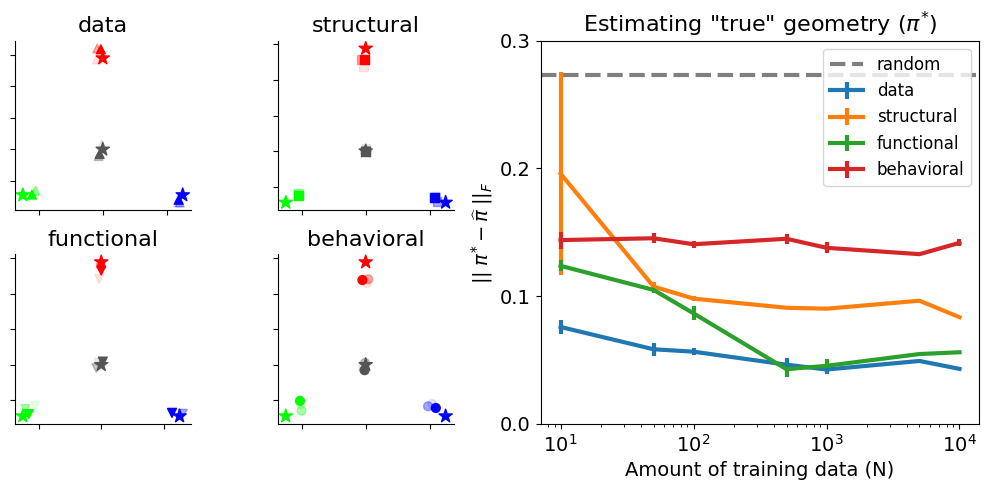

In [97]:
#- Set up fig structure
def get_random_geometry(true_geometry):
    n, n_components=true_geometry.shape
    vectors = np.random.random(size=(n, n_components))
    
    dist_matrix = squareform(pdist(vectors))
    dist_matrix /= np.linalg.norm(dist_matrix)
    
    cmds = ClassicalMDS(n_components=n_components).fit_transform(dist_matrix)
    
    return rotate_geometry(true_geometry, cmds)


fig = plt.figure(figsize=(10,5))
gs = fig.add_gridspec(2, 4)

cached_geometries = pickle.load(open(cache_file_path, 'rb'))

lora_rank=64
mc=0

alpha_dict = {50: 1/10, 500: 1/3, 5000: 1}
marker_dict = {'dataset': '^', 'structure': 's', 'functional': 'v', 'behavioral': 'o'}

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[:2, 2:4])
ax5.set_title(r'Estimating "true" geometry ($\pi^{*}$)', fontsize=16)

#- Plot dots
ax = [ax1,ax2,ax3,ax4]
title_dict = {'dataset': 'data',
             'structure': 'structural',
             'functional': 'functional',
             'behavioral': 'behavioral'
}

true_geometry = true_geometry_dict[5000][lora_rank][0]
for i, key in enumerate(cached_geometries):
    if key == 'true':
        continue
        
    i -= 1
    ax[i].scatter(true_geometry[:, 0], true_geometry[:, 1], c=true_pi_list, marker='*', s=100, alpha=alpha_dict[5000])
    
    for N in N_list:
        if N not in alpha_dict:
            continue

        geometry = cached_geometries[key][N][lora_rank][mc]

        alpha=alpha_dict[N]
        ax[i].scatter(geometry[:, 0], geometry[:, 1], 
                   c=true_pi_list, marker=marker_dict[key], alpha=alpha, s=40)

    xlim, ylim = ax[i].get_xlim(), ax[i].get_ylim()
    
#     ax[row,col].scatter(100, 100, marker=marker_dict[key], c='k', alpha=alpha)
#     ax[row,col].scatter(100, 100, marker='*', label='true geometry', c='k', s=50)
    ax[i].set_xlim(*xlim), ax[i].set_ylim(*ylim)
    ax[i].set_title(f'{title_dict[key]}', fontsize=16)
    
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
    
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    

#- Calculate average estimation error
distance_dict = {key: {} for key in cached_geometries if key != 'true'}

n_components=3
for N in N_list:
    for type_ in distance_dict:
        distance_dict[type_][N] = []
    for mc in range(n_mc):
        
        if N == 5000 and mc > 0:
            continue
        temp_true = cached_geometries['true'][N][64][mc]
        
        for key in cached_geometries:
            if key == 'true':
                continue
        
            temp = cached_geometries[key][N][64][mc]
            distance_dict[key][N].append(np.linalg.norm(temp[:,:n_components] - temp_true[:,:n_components]))
            
#- Plot average estimation errors
ax5.set_xticks(N_list)
ax5.set_xlabel('Amount of training data (N)', fontsize=14)
ax5.set_ylabel(r'$ ||\;\pi^{*} - \widehat{\pi}\;||_{F} $', fontsize=14)

for key in distance_dict:
    mean_list = [np.mean(distance_dict[key][N]) for N in N_list]
    std_list = [np.std(distance_dict[key][N]) / np.sqrt(n_mc) for N in N_list]
    
    ax5.errorbar(N_list, mean_list, std_list, label=title_dict[key], lw=3)
    
true_geometry = cached_geometries['true'][5000][64][0]
random_errors = [np.linalg.norm(get_random_geometry(true_geometry) - true_geometry) for i in range(1000)]

ax5.axhline(y = np.mean(random_errors), c='k', lw=3, ls='--', alpha=0.5, label='random')
    
ax5.set_yticks([0, 0.1, 0.2, 0.3])
ax5.set_xscale('log')
ax5.tick_params(labelsize=14)
ax5.legend(fontsize=12)
    
plt.tight_layout()

In [65]:
n_components=3
for N in N_list:
    for type_ in distance_dict:
        distance_dict[type_][N] = []
    for mc in range(n_mc):
        temp_true = cached_geometries['true'][N][64][mc]
        
        for key in cached_geometries:
            if key == 'true':
                continue
        
            temp = cached_geometries[key][N][64][mc]
            distance_dict[key][N].append(np.linalg.norm(temp[:,:n_components] - temp_true[:,:n_components]))
for key in distance_dict:
    mean_list = [np.mean(distance_dict[key][N]) for N in N_list]
    
    print(mean_list)

[0.05837925396520027]
[0.10750864310914524]
[0.1094185726817917]
[0.2635615981414986]


In [71]:
n_components=3
for N in N_list:
    for type_ in distance_dict:
        distance_dict[type_][N] = []
    for mc in range(n_mc):
        temp_true = cached_geometries['true'][N][64][mc]
        
        for key in cached_geometries:
            if key == 'true':
                continue
        
            temp = cached_geometries[key][N][64][mc]
            distance_dict[key][N].append(np.linalg.norm(temp[:,:n_components] - temp_true[:,:n_components]))
for key in distance_dict:
    mean_list = [np.mean(distance_dict[key][N]) for N in N_list]
    std_list = [np.std(distance_dict[key][N]) for N in N_list]
    
    print(mean_list, std_list)

[0.05837925396520027] [0.011758361716491614]
[0.10750864310914524] [0.007393731748104033]
[0.10523105948652398] [0.004739078021385667]
[0.14117404620306287] [0.03283517383411363]
